In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score



In [2]:
# Load the dataset into a pandas DataFrame
df = pd.read_csv('../data/cleaned_data.csv', parse_dates=['Start', 'End'])

In [3]:


# Select the relevant experience metrics for clustering
experience_metrics = df[['Avg RTT DL (ms)', 'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)']]

# Standardize the data
scaler = StandardScaler()
scaled_experience_metrics = scaler.fit_transform(experience_metrics)

# Perform k-means clustering (k=3)
kmeans = KMeans(n_clusters=3, n_init=10,random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_experience_metrics)




# Calculate the centroid of each cluster
cluster_centroids = kmeans.cluster_centers_

# Calculate the Euclidean distance between each user's data point and the centroid of the less engaged cluster
engagement_score = []
for index, row in df.iterrows():
    user_data = scaled_experience_metrics[index]
    less_engaged_cluster = np.argmin(np.linalg.norm(cluster_centroids, axis=1))
    distance = np.linalg.norm(user_data - cluster_centroids[less_engaged_cluster])
    engagement_score.append(distance)

# Assign the engagement scores to the DataFrame
df['engagement_score'] = engagement_score


# Display the DataFrame with the assigned engagement scores
print(df[['MSISDN/Number', 'engagement_score']])


        MSISDN/Number  engagement_score
0        3.365922e+10          2.968073
1        3.366565e+10          1.883758
2        3.366447e+10          4.913894
3        3.360329e+10          3.949389
4        3.365922e+10          3.757785
...               ...               ...
146877   3.366865e+10          5.189102
146878   3.365069e+10          3.634666
146879   3.366345e+10          3.631952
146880   3.362189e+10          3.550910
146881   3.361962e+10          3.566010

[146882 rows x 2 columns]


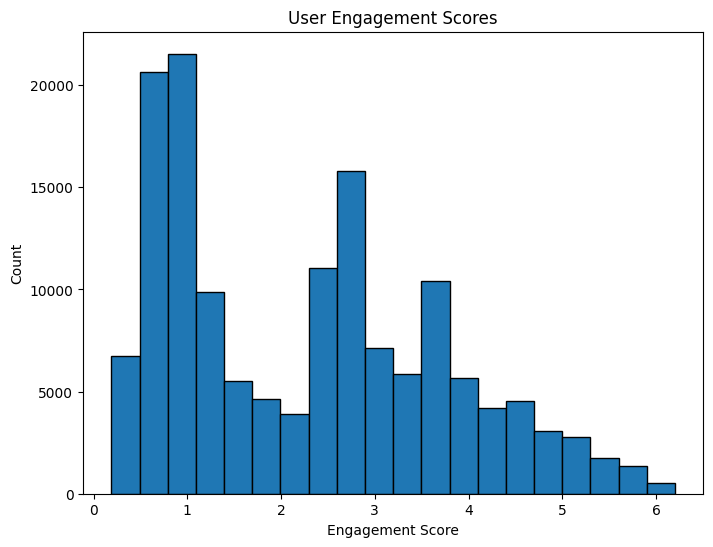

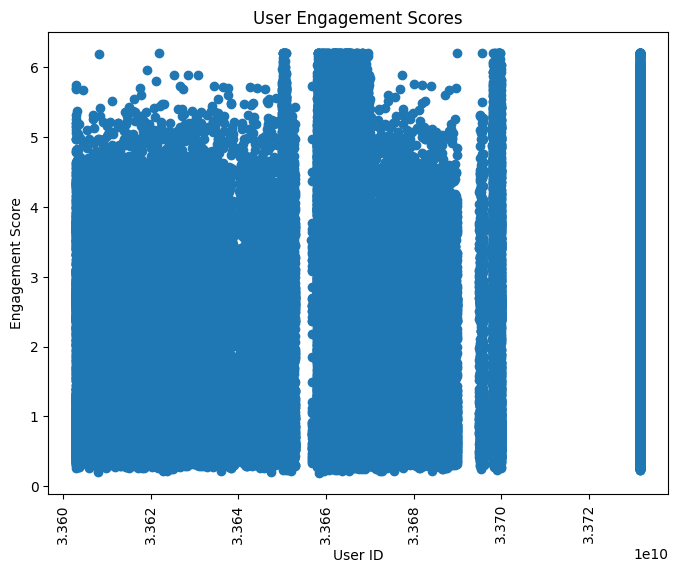

In [11]:
import matplotlib.pyplot as plt

# Create a histogram of the engagement scores
plt.figure(figsize=(8, 6))
plt.hist(df['engagement_score'], bins=20, edgecolor='black')
plt.xlabel('Engagement Score')
plt.ylabel('Count')
plt.title('User Engagement Scores')
plt.show()

# Create a scatter plot of the engagement scores
plt.figure(figsize=(8, 6))
plt.scatter(df['MSISDN/Number'], df['engagement_score'])
plt.xlabel('User ID')
plt.ylabel('Engagement Score')
plt.title('User Engagement Scores')
plt.xticks(rotation=90)
plt.show()


## Euclidean distance between each user's data point and the centroid of the worst experience's cluster

In [4]:
# Calculate the Euclidean distance between each user's data point and the centroid of the worst experience's cluster
experience_score = []
for index, row in df.iterrows():
    user_data = scaled_experience_metrics[index]
    worst_experience_cluster = np.argmax(np.linalg.norm(cluster_centroids, axis=1))
    distance = np.linalg.norm(user_data - cluster_centroids[worst_experience_cluster])
    experience_score.append(distance)

# Assign the experience scores to the DataFrame
df['experience_score'] = experience_score

# Display the DataFrame with the assigned experience scores
print(df[['MSISDN/Number', 'experience_score']])

        MSISDN/Number  experience_score
0        3.365922e+10          2.553181
1        3.366565e+10          3.444565
2        3.366447e+10          3.055363
3        3.360329e+10          4.183173
4        3.365922e+10          2.987121
...               ...               ...
146877   3.366865e+10          3.192933
146878   3.365069e+10          4.399533
146879   3.366345e+10          4.369239
146880   3.362189e+10          4.083725
146881   3.361962e+10          4.169611

[146882 rows x 2 columns]


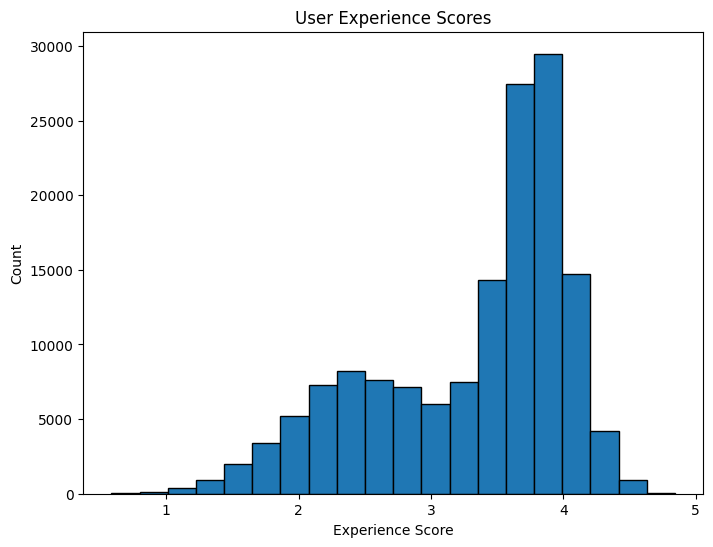

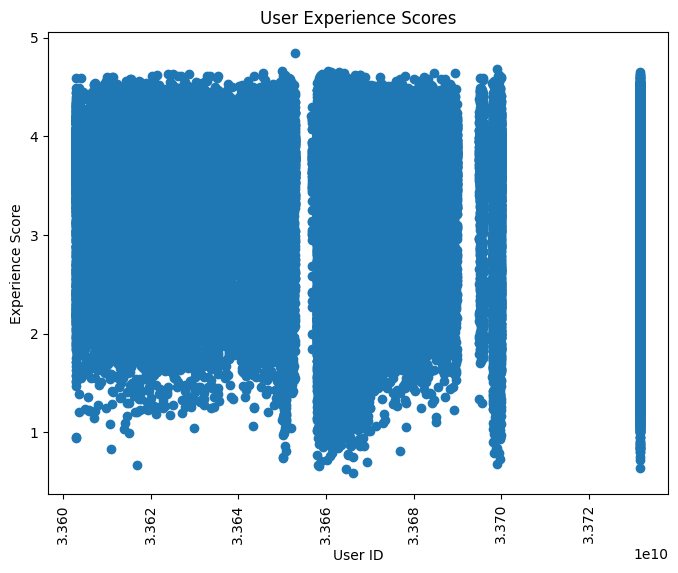

In [12]:
import matplotlib.pyplot as plt

# Create a histogram of the experience scores
plt.figure(figsize=(8, 6))
plt.hist(df['experience_score'], bins=20, edgecolor='black')
plt.xlabel('Experience Score')
plt.ylabel('Count')
plt.title('User Experience Scores')
plt.show()

# Create a scatter plot of the experience scores
plt.figure(figsize=(8, 6))
plt.scatter(df['MSISDN/Number'], df['experience_score'])
plt.xlabel('User ID')
plt.ylabel('Experience Score')
plt.title('User Experience Scores')
plt.xticks(rotation=90)
plt.show()


In [5]:
# Calculate the satisfaction score as the average of engagement and experience scores
df['satisfaction_score'] = (df['engagement_score'] + df['experience_score']) / 2

# Report the top 10 satisfied customers based on the satisfaction scores
top_satisfied_customers = df.nlargest(10, 'satisfaction_score')[['MSISDN/Number', 'satisfaction_score']]

# Display the top 10 satisfied customers
print(top_satisfied_customers)

      MSISDN/Number  satisfaction_score
644    3.366960e+10            4.739044
717    3.365099e+10            4.739044
1372   3.373167e+10            4.739044
1657   3.366178e+10            4.739044
1784   3.366459e+10            4.739044
1834   3.373167e+10            4.739044
2683   3.373167e+10            4.739044
3056   3.365812e+10            4.739044
3524   3.366539e+10            4.739044
3563   3.366295e+10            4.739044


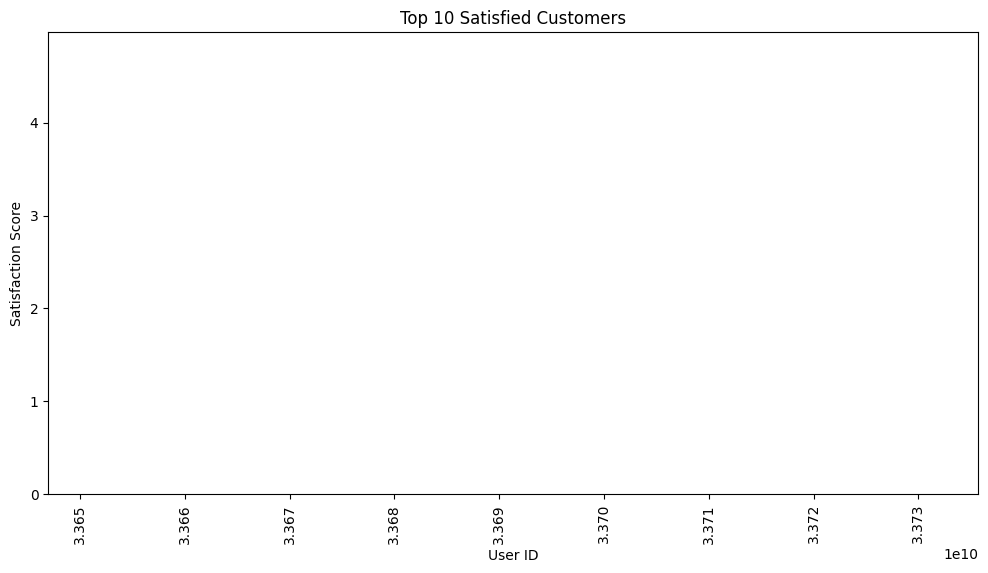

In [14]:
import matplotlib.pyplot as plt

# Calculate the satisfaction score as the average of engagement and experience scores
df['satisfaction_score'] = (df['engagement_score'] + df['experience_score']) / 2

# Report the top 10 satisfied customers based on the satisfaction scores
top_satisfied_customers = df.nlargest(10, 'satisfaction_score')[['MSISDN/Number', 'satisfaction_score']]

# Check if the top_satisfied_customers DataFrame is empty
if top_satisfied_customers.empty:
    print("No data available to plot.")
else:
    # Create a bar plot of the top 10 satisfied customers
    plt.figure(figsize=(12, 6))
    plt.bar(top_satisfied_customers['MSISDN/Number'], top_satisfied_customers['satisfaction_score'])
    plt.xlabel('User ID')
    plt.ylabel('Satisfaction Score')
    plt.title('Top 10 Satisfied Customers')
    plt.xticks(rotation=90)
    plt.show()



In [6]:


# Select features and target
X = df[['engagement_score', 'experience_score']]
y = df['satisfaction_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build and train the regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Make predictions
y_pred = regression_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 5.705828483839574e-31
R-squared: 1.0


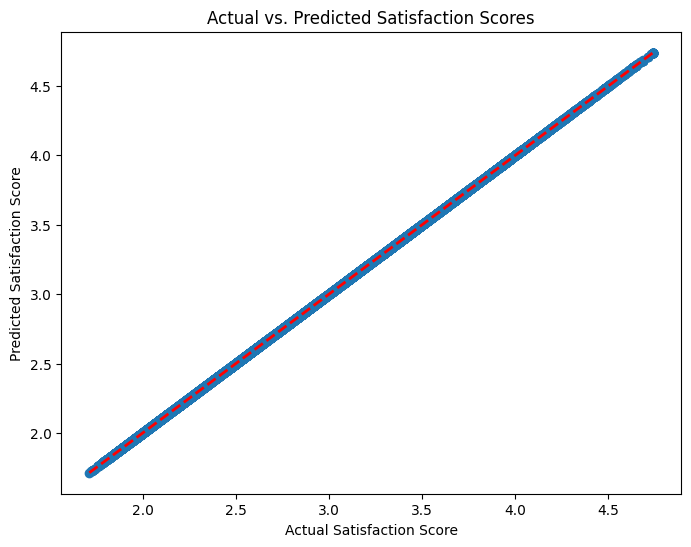

In [15]:


# Create a scatter plot of actual vs. predicted satisfaction scores
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', linewidth=2)
plt.xlabel('Actual Satisfaction Score')
plt.ylabel('Predicted Satisfaction Score')
plt.title('Actual vs. Predicted Satisfaction Scores')
plt.show()


In [7]:
# Select the relevant features for clustering (engagement and experience scores)
features = df[['engagement_score', 'experience_score']]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform k-means clustering (k=2)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_features)

# Display the DataFrame with the assigned k-means clusters
print(df[['engagement_score', 'experience_score', 'kmeans_cluster']])

        engagement_score  experience_score  kmeans_cluster
0               2.968073          2.553181               1
1               1.883758          3.444565               0
2               4.913894          3.055363               1
3               3.949389          4.183173               0
4               3.757785          2.987121               1
...                  ...               ...             ...
146877          5.189102          3.192933               1
146878          3.634666          4.399533               0
146879          3.631952          4.369239               0
146880          3.550910          4.083725               0
146881          3.566010          4.169611               0

[146882 rows x 3 columns]


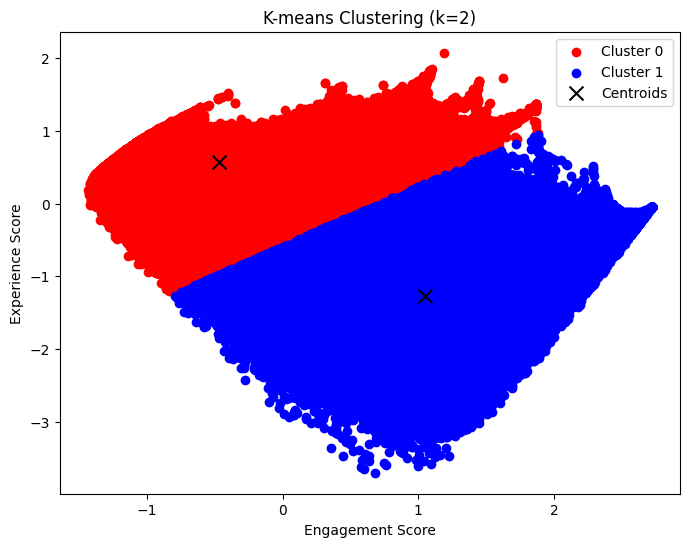

In [16]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select the relevant features for clustering (engagement and experience scores)
features = df[['engagement_score', 'experience_score']]

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform k-means clustering (k=2)
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_features)

# Create a scatter plot of the clustered data
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features[df['kmeans_cluster'] == 0, 0], scaled_features[df['kmeans_cluster'] == 0, 1], c='r', label='Cluster 0')
plt.scatter(scaled_features[df['kmeans_cluster'] == 1, 0], scaled_features[df['kmeans_cluster'] == 1, 1], c='b', label='Cluster 1')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='k', marker='x', label='Centroids')
plt.xlabel('Engagement Score')
plt.ylabel('Experience Score')
plt.title('K-means Clustering (k=2)')
plt.legend()
plt.show()


In [8]:
df['kmeans_cluster'].value_counts()

kmeans_cluster
0    101497
1     45385
Name: count, dtype: int64

In [9]:
# Aggregate the average satisfaction and experience scores per cluster
cluster_scores = df.groupby('kmeans_cluster')[['satisfaction_score', 'experience_score']].mean()

# Display the average satisfaction and experience scores per cluster
print(cluster_scores)

                satisfaction_score  experience_score
kmeans_cluster                                      
0                         2.659615          3.733019
1                         3.078954          2.375090


<Figure size 1000x600 with 0 Axes>

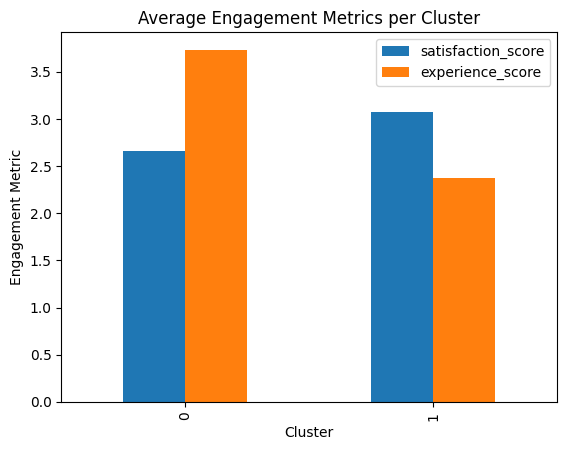

In [10]:
import matplotlib.pyplot as plt

# Plot the scores
plt.figure(figsize=(10, 6))
cluster_scores.plot(kind='bar')
plt.title('Average Engagement Metrics per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Engagement Metric')
plt.legend()
plt.show()
